In [29]:
%config InlineBackend.figure_format = 'retina'
# packages for basic operations and data manipulation
import os
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm; tqdm.pandas()
plt.style.use('seaborn')
cwd = os.getcwd()

from utility import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import category_encoders as ce
import shap

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/frank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read in data
post = pd.read_csv(cwd+'/data/post_metrics_and_comments.csv')
htag = pd.read_csv(cwd+'/data/hashtag_top_appearances.csv')
rawp = pd.read_csv(cwd+'/data/raw_post_metrics.csv')
print('post_metrics_and_comments.csv has {} rows and {} columns'.format(post.shape[0],post.shape[1]))
print('hashtag_top_appearances.csv has {} rows and {} columns'.format(htag.shape[0],htag.shape[1]))
print('raw_post_metrics.csv has {} rows and {} columns'.format(rawp.shape[0],rawp.shape[1]))

post_metrics_and_comments.csv has 11637 rows and 11 columns
hashtag_top_appearances.csv has 25062 rows and 2 columns
raw_post_metrics.csv has 70532 rows and 5 columns


In [ ]:
post = post.merge(htag)
rawp = post.merge(rawp)

# Remove "|, @, #" in comments and translate into English
post['en_comment'] = post.concatenated_comments.progress_apply(process_comment)
trans(post)

# Calculate comments length and counts
post['comment_length'] = post.en_comment.progress_apply(len)
post['comment_count'] = post.concatenated_comments.progress_apply(lambda x: x.count('|'))

# Calculate emoji counts and emoji rates in comments
post['comment_emojicount'] = post.concatenated_comments.progress_apply(countemoji)
post['comment_emojirate'] = post.comment_emojicount / (post.comment_length+1)

# Calculate comments sentiment score
post['comment_sentiment'] = post.en_comment.progress_apply(sentiment)

# Calculate datetime and generate weekdays
post['weekday'] = post.date_posted.progress_apply(getweekday)
rawp['date_posted'] = rawp.date_posted.progress_apply(getdate1)
rawp['date_time_collected'] = rawp.date_time_collected.progress_apply(getdate2)

# Calculate likes & comments per day
rawp['daydelta'] = rawp.date_time_collected-rawp.date_posted
rawp['daydelta'] = rawp['daydelta'].dt.days
rawp = rawp.groupby(['post_url', 'max_likes', 'max_comments'], as_index=False)['daydelta'].max()
rawp = rawp[rawp.daydelta>=1]
rawp.loc[:,'likes_per_day'] = rawp.max_likes/rawp.daydelta
rawp.loc[:,'comments_per_day'] = rawp.max_comments/rawp.daydelta
post = rawp.merge(post)

# Calculate comments per likes for each posts
post['comments/likes'] = post.max_comments / (post.max_likes+1)

# Calculate posts per day
post_count = post[['username','date_posted']].groupby(['username'], 
            as_index=False).count().rename(columns={"date_posted": "post_counts"})
post = post.merge(post_count)
post['posts_per_day'] = post.post_counts / 26 # (from 4/1 to 4/26)

# Generate a classification target variable
post.loc[post.days_in_hashtag_top_section == 0 ,'trending'] = 0
post.loc[post.days_in_hashtag_top_section != 0 ,'trending'] = 1

#post.to_pickle("./post.pkl")

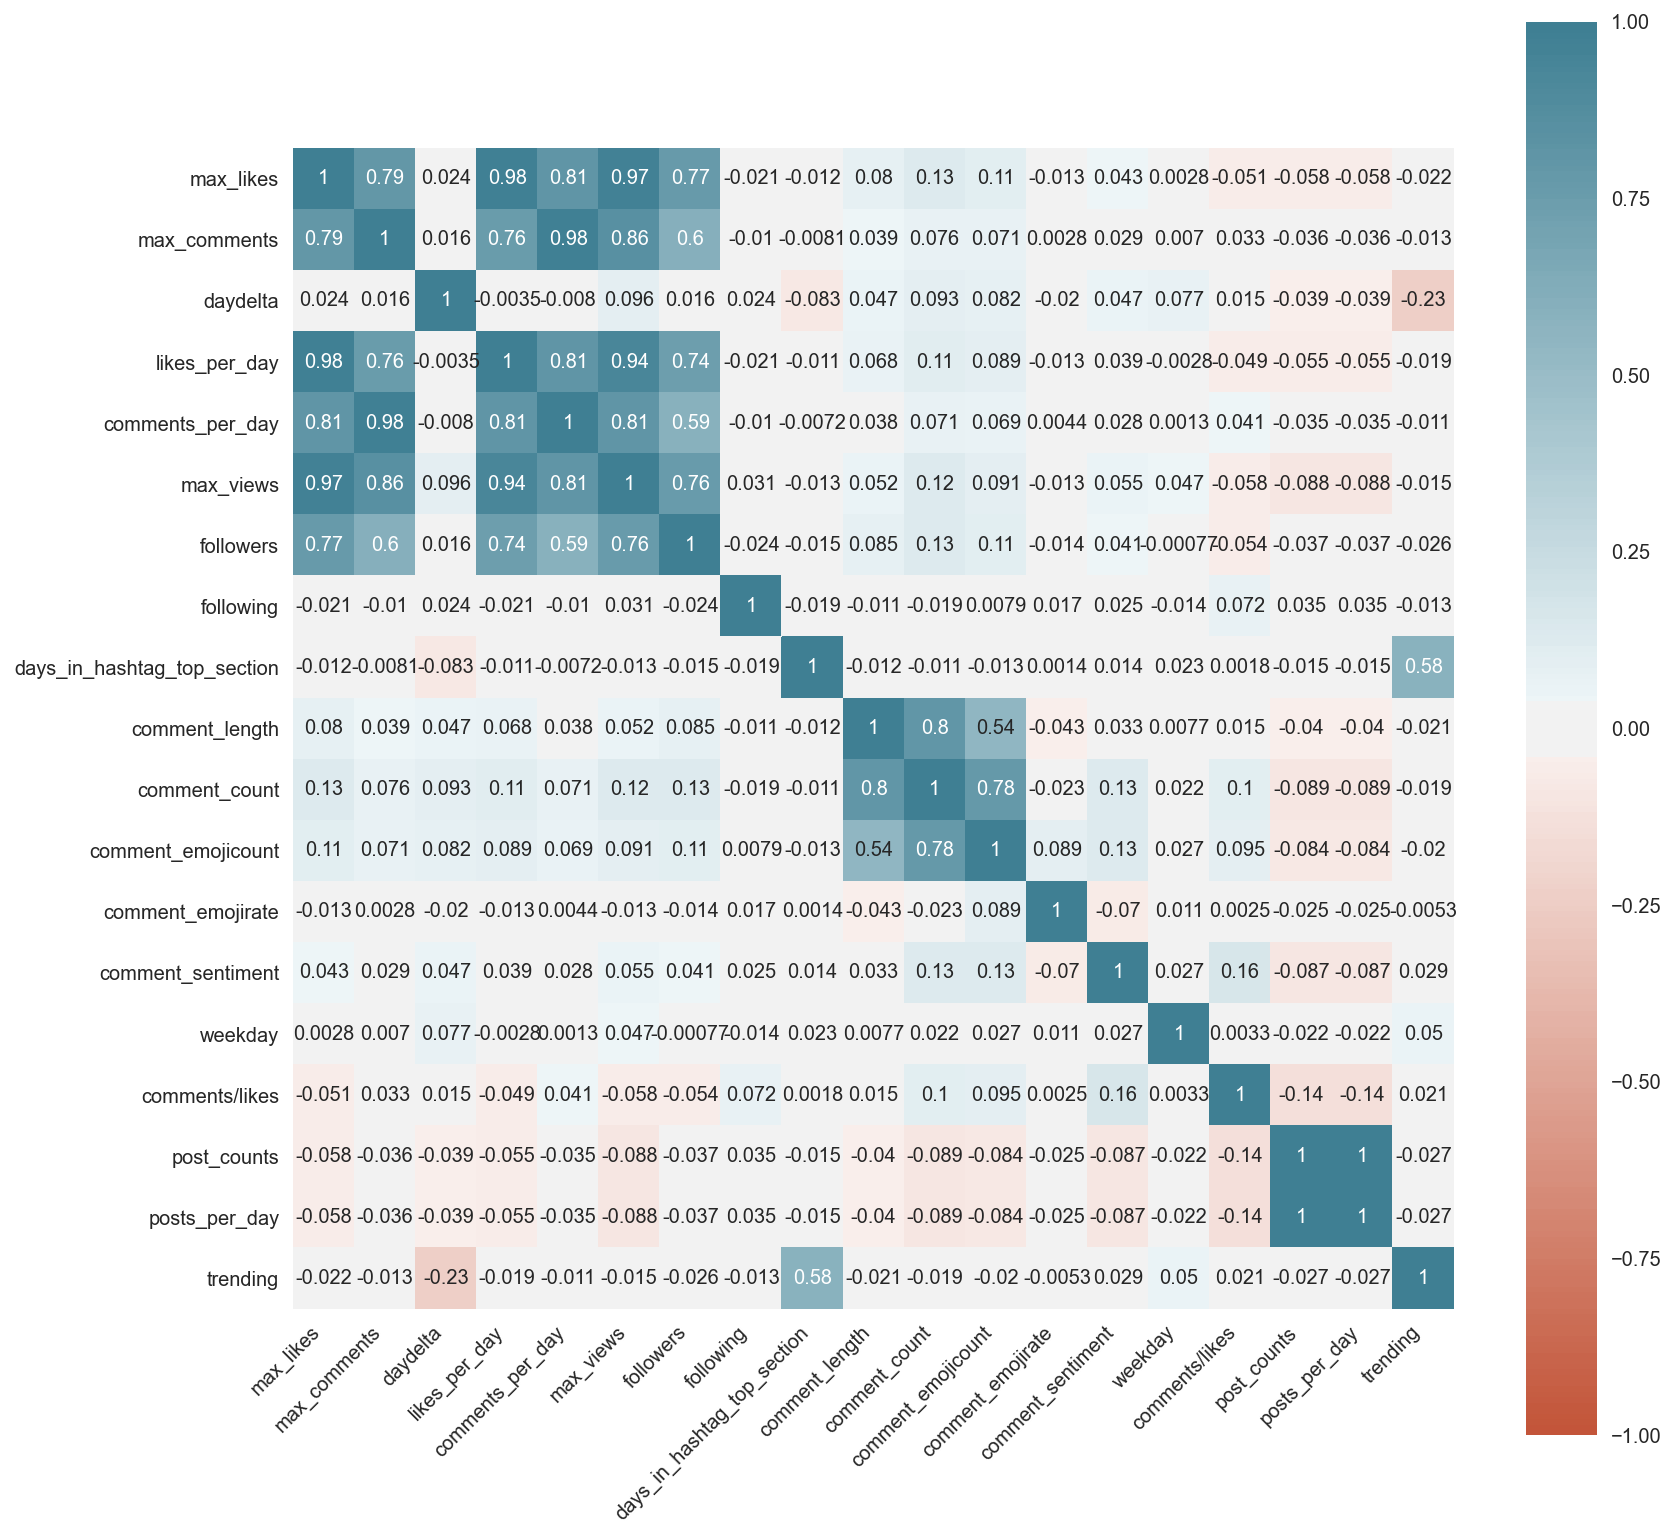

In [102]:
post = pd.read_pickle("./post.pkl")

data = post[['username', 'max_likes', 'max_comments', 'likes_per_day', 'comments_per_day',
             'followers', 'following', 'comment_length', 'comment_count', 'comment_sentiment', 
             'weekday', 'comment_emojirate', 'trending', 'days_in_hashtag_top_section', 
             'posts_per_day', 'comments/likes']]
# Plotting correlation matrix
fig = plt.figure(figsize=(13, 13))
ax = sns.heatmap(post.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### Classification

In [103]:
data = data[['username', 'max_likes', 'max_comments', 'likes_per_day', 'comments_per_day',
             'followers', 'following', 'comment_length', 'comment_count', 'comment_sentiment', 
             'weekday', 'comment_emojirate', 'trending', 'posts_per_day', 'comments/likes']]

X = data.drop(columns=['trending'])
y = data['trending']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
encoder = ce.TargetEncoder(cols=['username'])
# Make sure to use only training data to train the encoder
X_trainec = encoder.fit_transform(X_train, y_train)
X_testec = encoder.transform(X_test)
X_ec = encoder.transform(X)

SS = StandardScaler()
X_trainec_norm = pd.DataFrame(data = SS.fit_transform(X_trainec), columns = X.columns)
X_testec_norm = pd.DataFrame(data = SS.transform(X_testec), columns = X.columns)
X_ec_norm = pd.DataFrame(data = SS.transform(X_ec), columns = X.columns)

In [124]:
# Create the random grid
param_grid = {# Maximum tree leaves for base learners.
              'num_leaves': [4, 8, 16, 32, 64],
              # Minimum number of data needed in a child (leaf).
              'min_child_samples': [2, 4, 8, 16],
              # Maximum tree depth for base learners.
              'max_depth': [3, 4, 5, 6],
              # Learning Rate
              'learning_rate': [0.05, 0.08, 0.1, 0.12],
              # L1 Regularization
              'reg_alpha': [0, 1],
              # L2 Regularization
              'reg_lambda': [0, 1],}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = LGBMClassifier(), 
                           param_grid = param_grid, 
                           cv = 3, n_jobs = 1, verbose = 1)

grid_search.fit(X_trainec_norm, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

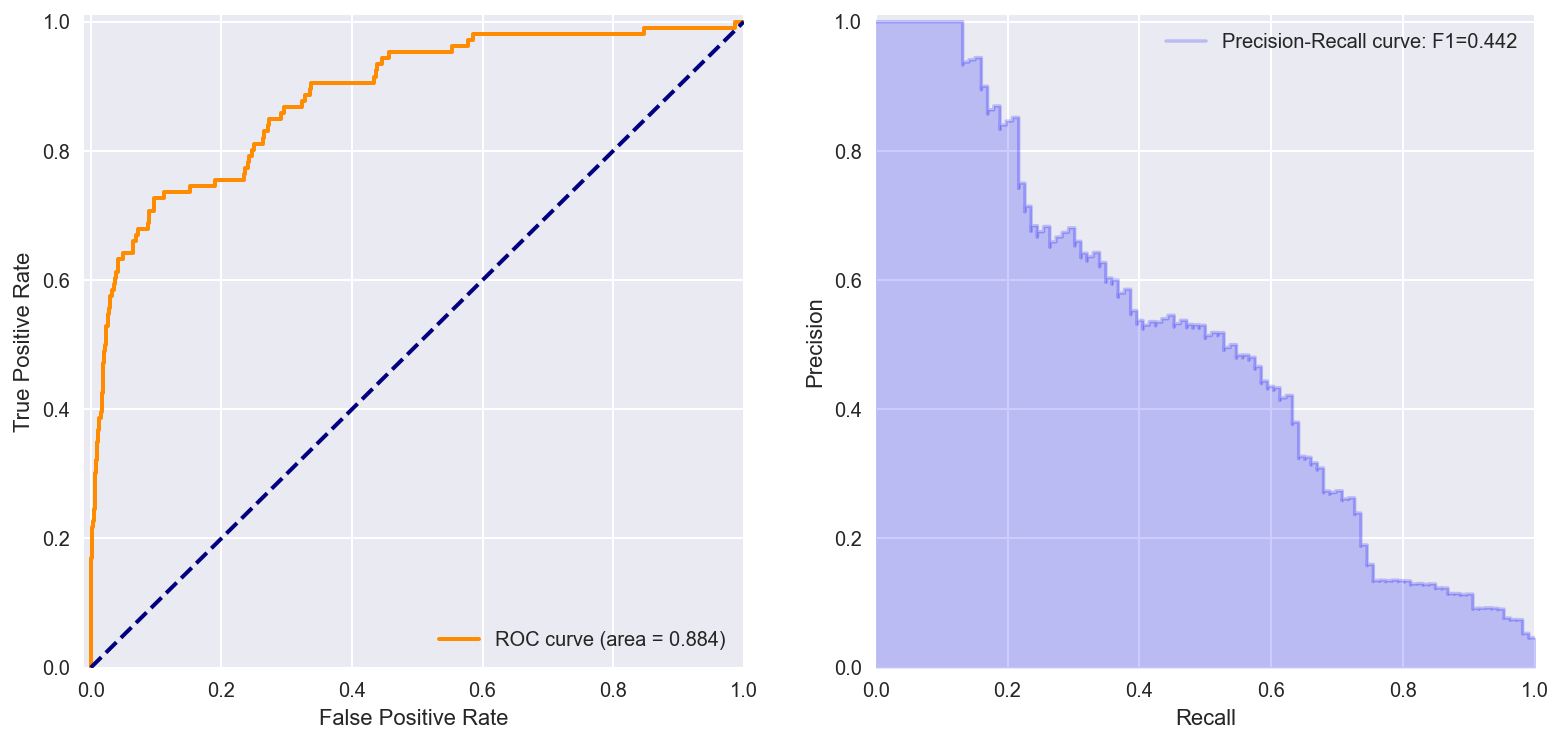

In [104]:
lgbm = LGBMClassifier(n_jobs = -1, random_state=0)
y_pred = lgbm.fit(X_trainec_norm, y_train).predict_proba(X_testec_norm).T[1]
fig = plt.figure(figsize=(13, 6))
plot_curves(y_test, y_pred)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


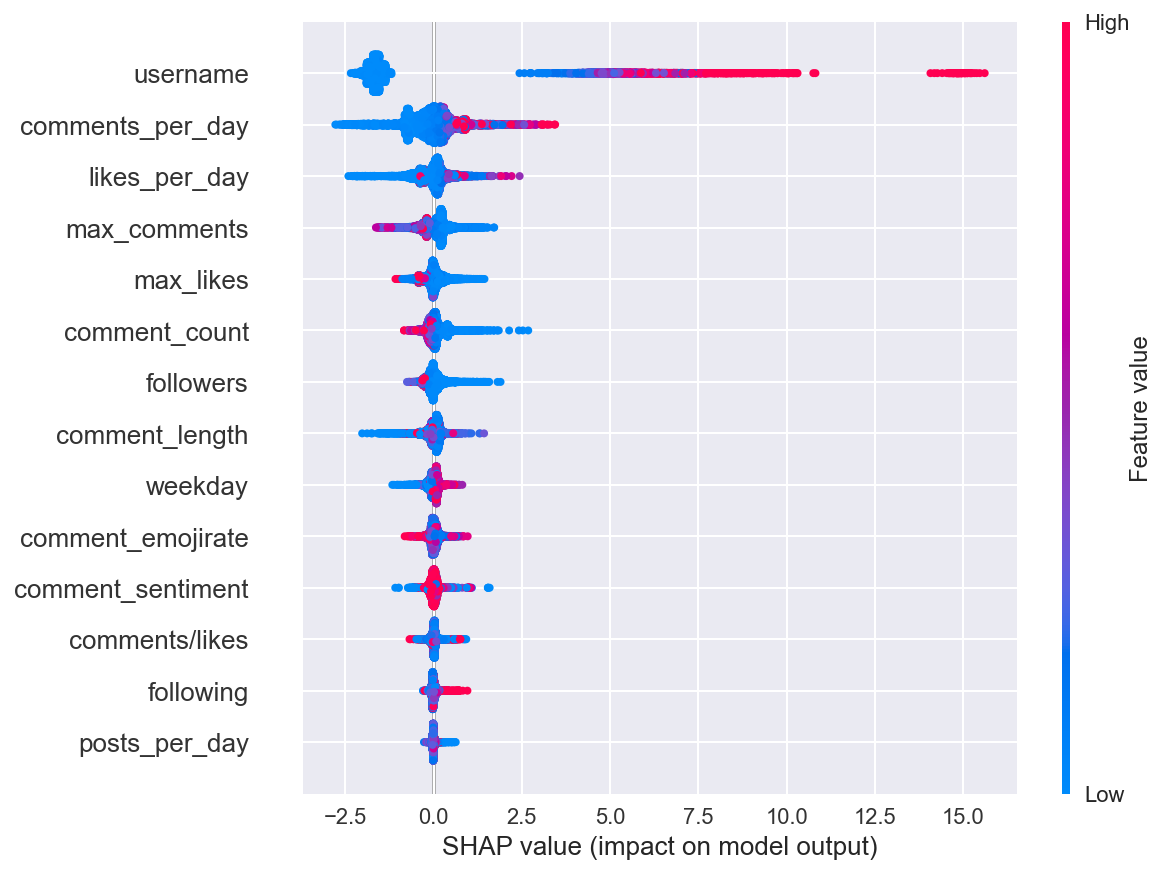

In [105]:
shap.initjs()
explainer = shap.TreeExplainer(lgbm)
shap_values = np.array(explainer.shap_values(X_trainec_norm))
shap.summary_plot(shap_values[1], X_trainec)

In [106]:
IMP = pd.DataFrame({'Feature': X.columns.values,
    'Importance': np.absolute(shap_values[1]).mean(axis = 0)}).sort_values(by = 'Importance', ascending = False)
IMP

,Feature,Importance
0,username,2.603397
4,comments_per_day,0.499854
3,likes_per_day,0.300840
2,max_comments,0.263475
1,max_likes,0.171834
8,comment_count,0.165287
5,followers,0.141113
7,comment_length,0.134901
10,weekday,0.100479
11,comment_emojirate,0.084914


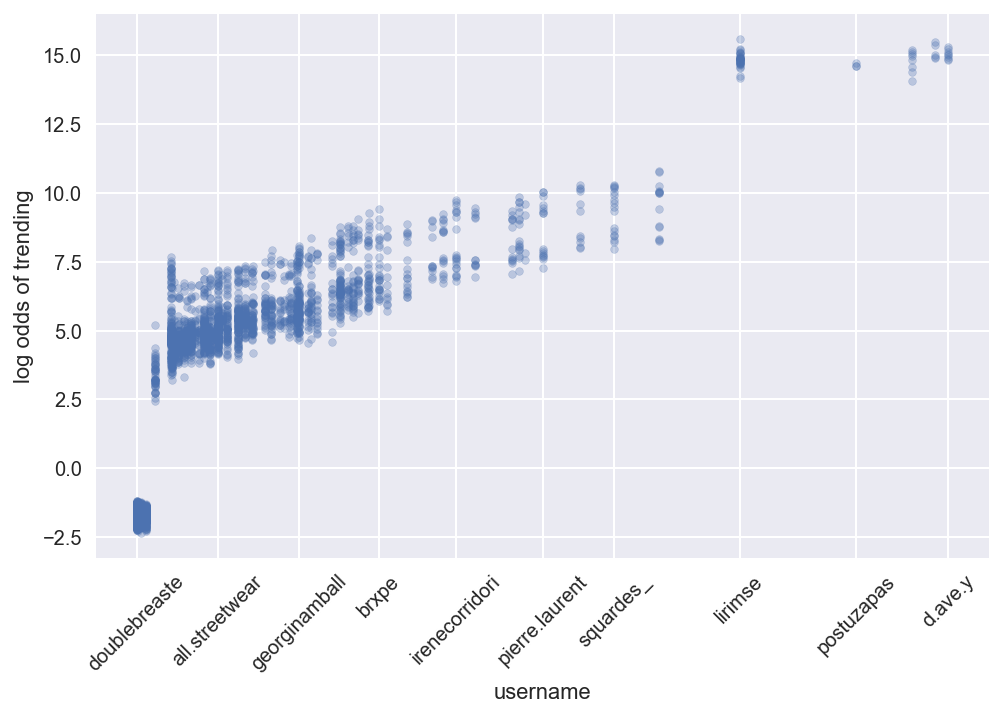

In [107]:
t = pd.DataFrame({'feat':X_trainec.username, 
                  'shap':shap_values[1].T[0]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
sample_idx = findindex(X_trainec)
plt.xticks(X_trainec.username[sample_idx], X_train.username[sample_idx], rotation = 45)
plt.xlabel('username'); plt.ylabel('log odds of trending')
plt.show()

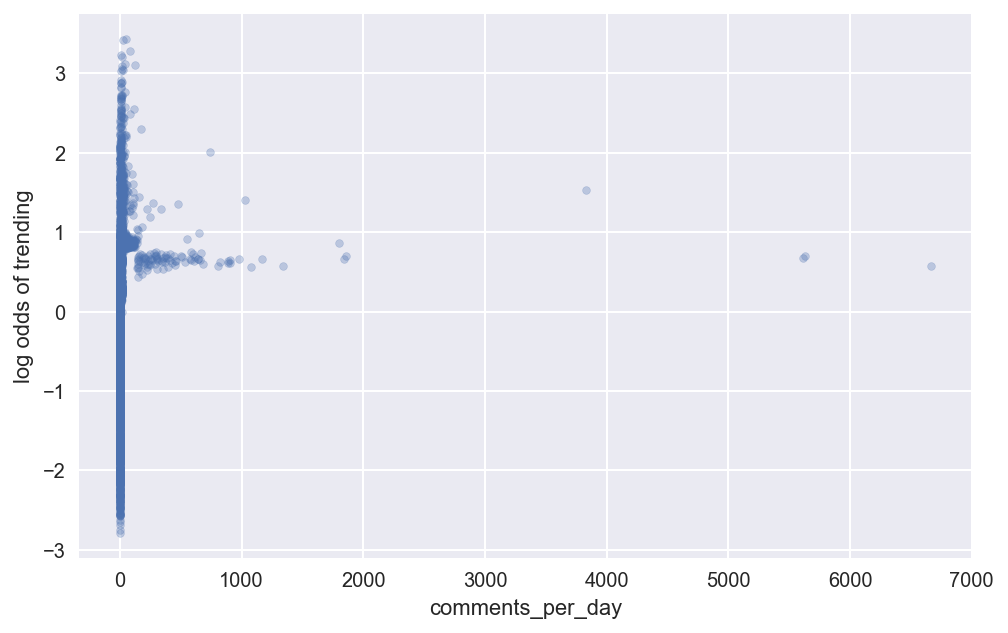

In [108]:
t = pd.DataFrame({'feat':X_trainec.comments_per_day, 
                  'shap':shap_values[1].T[4]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('comments_per_day'); plt.ylabel('log odds of trending')
plt.show()

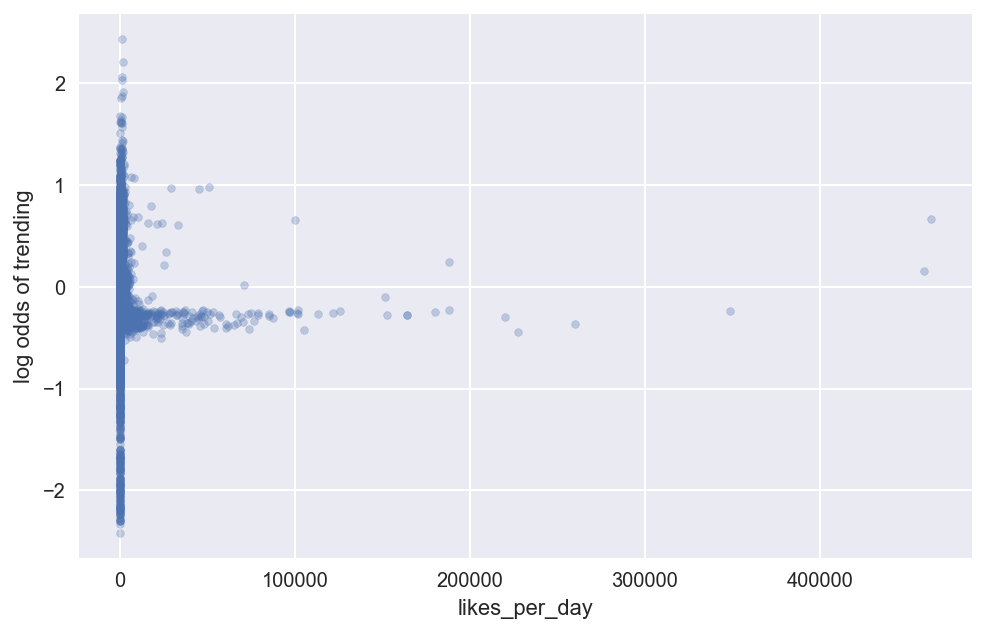

In [109]:
t = pd.DataFrame({'feat':X_trainec.likes_per_day, 
                  'shap':shap_values[1].T[3]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('likes_per_day'); plt.ylabel('log odds of trending')
plt.show()

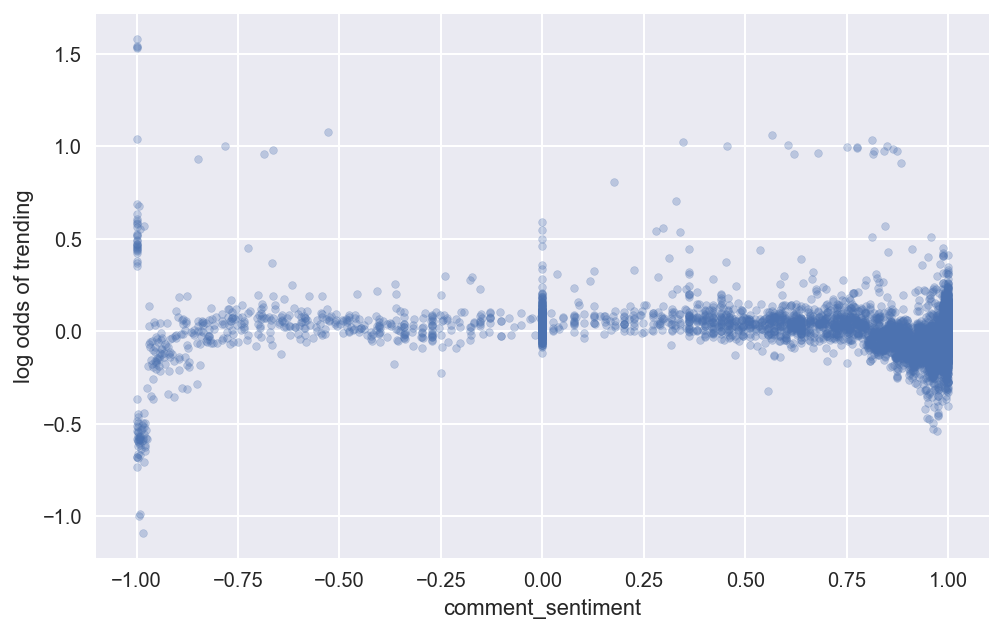

In [110]:
t = pd.DataFrame({'feat':X_trainec.comment_sentiment, 
                  'shap':shap_values[1].T[9]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('comment_sentiment'); plt.ylabel('log odds of trending')
plt.show()

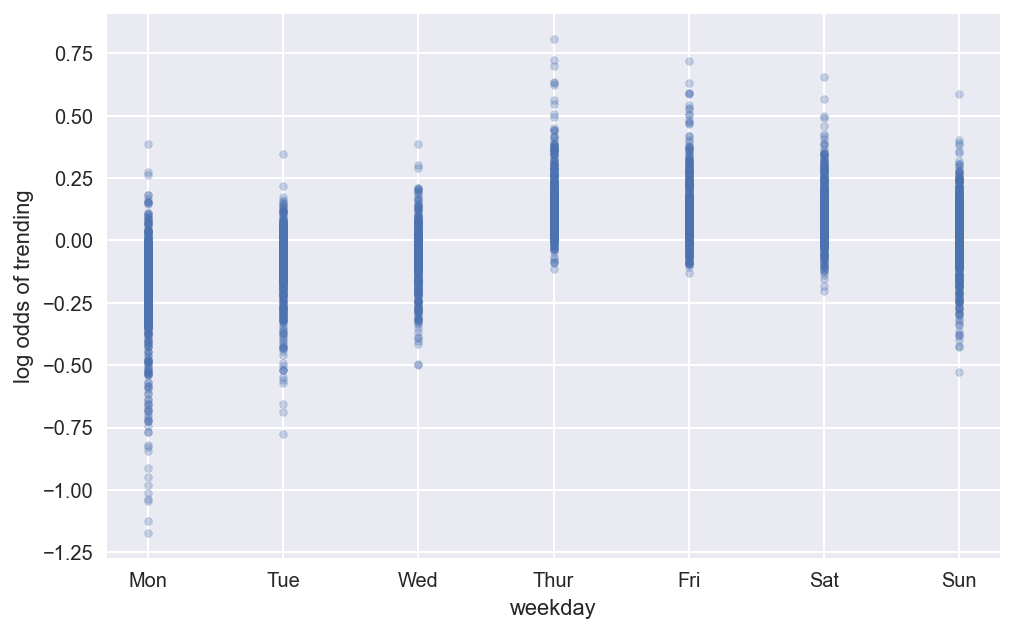

In [111]:
t = pd.DataFrame({'feat':X_trainec.weekday, 
                  'shap':shap_values[1].T[10]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday'); plt.ylabel('log odds of trending')
plt.show()

In [112]:
post['pred'] = lgbm.predict_proba(X_ec_norm).T[1]

In [113]:
post.sort_values(by = 'pred', 
                 ascending = False)[['post_url', 'username', 'days_in_hashtag_top_section', 'pred', 'trending']].head(20)

,post_url,username,days_in_hashtag_top_section,pred,trending
11588,https://www.instagram.com/p/B_akSN6lzN-/,latashalauren,2,0.999533,1.0
11587,https://www.instagram.com/p/B_X_lFfF3aN/,latashalauren,2,0.999502,1.0
11566,https://www.instagram.com/p/B_aHtncgiqY/,nur.rr,1,0.999499,1.0
11576,https://www.instagram.com/p/B_ajxQLg6ko/,_annafarkas,3,0.999430,1.0
11565,https://www.instagram.com/p/B_StSIwgtB3/,nur.rr,2,0.999421,1.0
11370,https://www.instagram.com/p/B_ahhGTKWPW/,outfitsofmunich,6,0.999398,1.0
11558,https://www.instagram.com/p/B_ajoxYo_t8/,jason.kural,2,0.999370,1.0
9294,https://www.instagram.com/p/B_XpbBvpn1C/,d.ave.y,2,0.999336,1.0
11366,https://www.instagram.com/p/B_UwIIhKaTt/,outfitsofmunich,3,0.999304,1.0
11602,https://www.instagram.com/p/B_Zuf1AHDUe/,peipay97,1,0.999254,1.0


In [114]:
post.sort_values(by = 'days_in_hashtag_top_section', 
                 ascending = False)[['post_url', 'username', 'days_in_hashtag_top_section', 'pred', 'trending']].head(20)

,post_url,username,days_in_hashtag_top_section,pred,trending
8249,https://www.instagram.com/p/B-cuVYrJncn/,xxlexx007,36,0.777721,1.0
10028,https://www.instagram.com/p/B_CHJzXDeNF/,vinceropitini,33,0.015061,1.0
8961,https://www.instagram.com/p/B-_07jGpiWT/,squardes_,29,0.935355,1.0
8962,https://www.instagram.com/p/B-xB_snKjld/,squardes_,29,0.876753,1.0
5707,https://www.instagram.com/p/B-9fgRUqRo5/,misfashionedsneakers,28,0.913038,1.0
9723,https://www.instagram.com/p/B_HxniXh4lX/,tylerlovence,28,0.825200,1.0
11513,https://www.instagram.com/p/B_Vb9NCJ1nh/,hbcudrip,25,0.824564,1.0
8965,https://www.instagram.com/p/B_E-6C2pWc5/,squardes_,25,0.848863,1.0
2516,https://www.instagram.com/p/B_FovwcH1Vq/,f41co,23,0.998002,1.0
5704,https://www.instagram.com/p/B-4GhjnK7Uk/,misfashionedsneakers,21,0.892559,1.0
